## Objective

In this notebook, we give an example of how to implement Bayesian decisions on dummy 2-d data belonging to three different classes. The samples were randomly generated with three different "unknown" Gaussians.

We will first consider the three classes as equiprobable. Three models will be fit and used to make predictions on new samples based on the Maximum Likelihood criterium.

Then, we will see how to plot isocontours also called level curves, and how to boundary decisions.

More math details can be found in http://cs229.stanford.edu/section/gaussians.pdf


## Setup and load the 2-d dummy samples

In [2]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from math import pi as PI
from grader import Grader
from scipy.stats import norm
%matplotlib inline

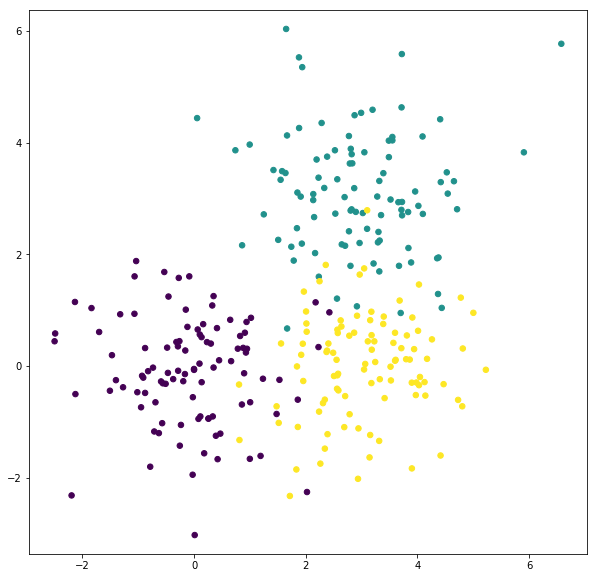

In [3]:
samples = np.load('samples.npz')
X = samples['samples']

C, N_per_class, d = X.shape
X = np.reshape(X, (C*N_per_class, d))
y=np.concatenate((np.zeros((N_per_class,)), np.ones((N_per_class,)), 2*np.ones((N_per_class,))))
N = X.shape[0]

plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=30)
plt.axis('equal')
plt.show()

## Fit a 2-d Gaussian for each class
Let's plot the histograms of the first component for the three classes and fit a simple Gaussian on each of them.

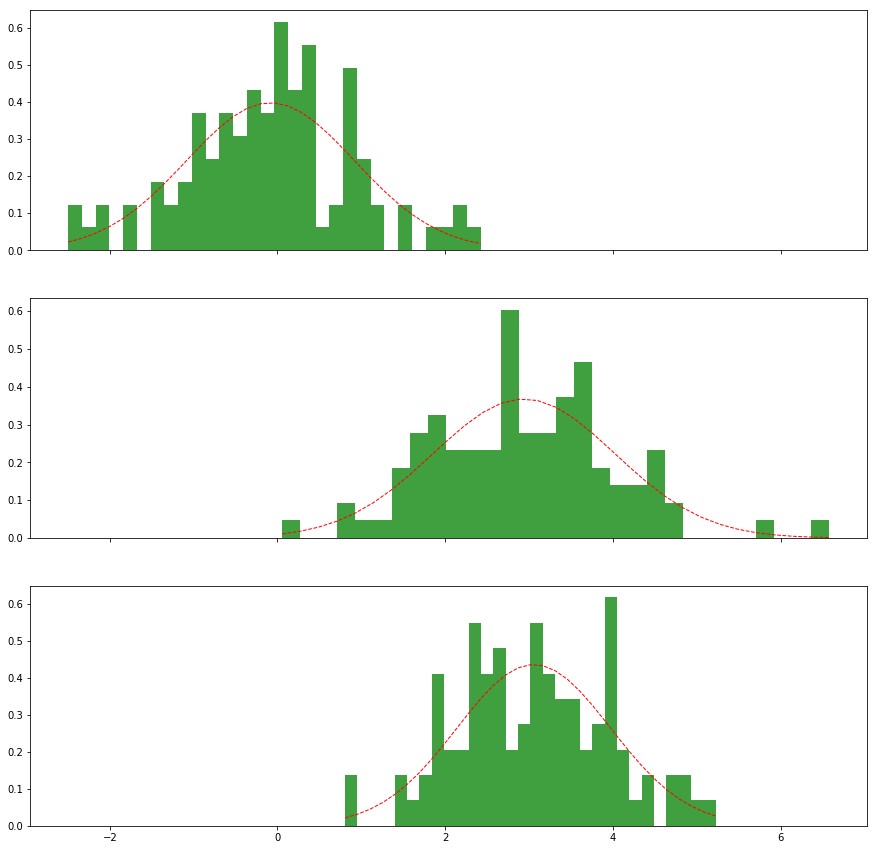

In [4]:
f, axarr = plt.subplots(C,figsize=(15,15), sharex=True)
for i in range(3):
    data = X[i*N_per_class:(i+1)*N_per_class,0]
    n, bins, patches = axarr[i].hist(data, 30, normed=1, facecolor='green', alpha=0.75)
    theo = norm.pdf(bins, np.mean(data), np.std(data))
    axarr[i].plot(bins, theo, 'r--', linewidth=1)
    # ax1.title('Class 0, component 0')

It looks reasonable to model the data by 2-dimensional Gaussian distributions, one for each class $c_i$: $x \sim \mathcal{N}(\mu_i, \Sigma_i)$

Let's write a function that assigns the mean and covariance matrix of a Gaussian with the empirical ones.

In [6]:
def fit_multivariate_Gaussian(data):
    return np.mean(data, axis=0), np.cov(data.T)

In [7]:
mu, sigma = [], [] # lists to store the Gaussian parameters for the three classes
for i in range(3):
    data = X[i*N_per_class:(i+1)*N_per_class]
    m, s = fit_multivariate_Gaussian(data)
    assert m.shape == (2,), 'ERROR on dimensions for mu'
    assert s.shape == (2,2), 'ERROR on dimensions for sigma'
    mu.append(m)
    sigma.append(s)

## Make a prediction on a new sample

We chose to use Gaussian distributions. They allow us to estimate the probability of observing a given point $x$ according to the distribution of a given class: $p(\mathbf{x}|c_i) = p(\mathbf{x}|c_i, \mu_i, \Sigma_i)=\displaystyle \frac{1}{(2\pi)^{d/2}|\Sigma_i|^{1/2}}\,\exp\Big(-\frac{1}{2}(\mathbf{x}-\mu_i)^t\Sigma_i^{-1}(\mathbf{x}-\mu_i)\Big)$

This probability is called *likelihood* and we usually take the log of it to ease the computations. The log-likelihood in our case results in:

$\log p(\mathbf{x}|c_i) = -\displaystyle \frac{d}{2}\log 2\pi -\frac{1}{2}\log |\Sigma_i|-\frac{1}{2}(\mathbf{x}-\mu_i)^t\Sigma_i^{-1}(\mathbf{x}-\mu_i)$

In [10]:
def compute_llh(data_point, mu, sigma):
    """computes the log-likelihood for a multivariate Gaussian distrib"""
    d = mu.shape[0]
    return -d/2.*np.log(2*PI) -0.5*np.linalg.det(sigma) -0.5*np.dot((data_point - mu).T, np.dot(np.linalg.inv(sigma), (data_point-mu)))

In [11]:
point = np.array([3.2696486, 0.49428706])
llhs = []
for i in range(3):
    llhs.append(compute_llh(point, mu[i], sigma[i]))
    print('class', i, 'llh:', llhs[-1])
predicted_class = np.argmax(np.array(llhs))
print('This point belongs to class', predicted_class, 'with probability %.3f'%np.exp(llhs[predicted_class]))

class 0 llh: -8.18862127124
class 1 llh: -5.43360187506
class 2 llh: -2.35092624723
This point belongs to class 2 with probability 0.095


## Isocontours

Isocontours or level curves are a set of points for which a function is constant: $\{x \in \mathbb{R}^d : f(x)=k, k\in \mathbb{R}\}$.

We can write a Gaussian as $p(\mathbf x|c)=\displaystyle \frac{\exp\big(-\frac{1}{2}u_c(\mathbf x)\big)}{Z}$, with $u_c(\mathbf x) = (\mathbf{x}-\mu_i)^t\Sigma_i^{-1}(\mathbf{x}-\mu_i)$. 

By the way, $u_c$ is called the Mahalannobis distance. This is the only term that depends on $\mathbf x$.

Thus, for a given constant $k\in \mathbb{R}$, we have $p(\mathbf x|c)=k$ equivalent to $u_c(\mathbf x)=k$.

The isocontours of a Gaussian are given by the equation: $(\mathbf{x}-\mu_i)^t\Sigma_i^{-1}(\mathbf{x}-\mu_i)=k$.

Let's plot them.

First, let's create a squared meshgrid between [-5, 5] for the two dimensions and centered on the origin, with $100\times100$ points. The contour plot needs a meshgrid to be defined.

In [13]:
x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)

xx, yy = np.meshgrid(x1, x2)
xx.shape, yy.shape

((100, 100), (100, 100))

We can rewrite the isocontour term into its expanded form:

$(\mathbf{x}-\mu_i)^t\Sigma_i^{-1}(\mathbf{x}-\mu_i)=(x_1 \,\, x_2)\,
\begin{pmatrix} 
a & b \\
c & d 
\end{pmatrix}
\, 
\begin{pmatrix} 
x_1\\
x_2 
\end{pmatrix}
= \ldots = ax_1^2+2bx_1x_2+dx_2^2
$.

and apply it to the meshgrid:

$z = a\,xx^2+2b\,xx\,yy + d\,yy^2$.

Then, we create a new meshgrid centered around the class mean used to plot two contour lines at the values 5 and 15, for instance.

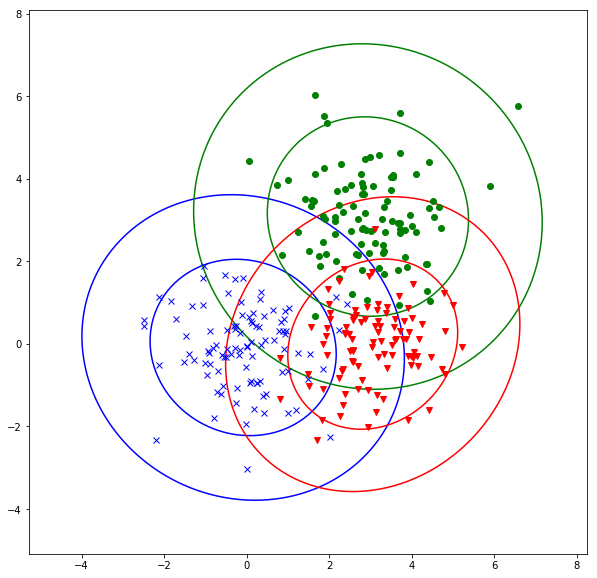

In [14]:
colors= [ 'b', 'g', 'r' ]
shapes = [ 'x', 'o', 'v']

plt.figure(figsize=(10,10))

for c in range(C):
    data = X[c*N_per_class:(c+1)*N_per_class]
    m = mu[c]
    s = sigma[c]
    inv_s = np.linalg.inv(s)
    
    stylepoint = shapes[c]+colors[c]
    plt.plot(data[:,0], data[:,1], stylepoint)
    
    # contour equation
    z = inv_s[0,0]*xx**2 + 2*inv_s[0,1]*xx*yy + inv_s[1,1]*yy**2
    
    # create a new meshgrid centered on the class mean
    x1_centered = x1 + m[0]
    x2_centered = x2 + m[1]
    xx_plot, yy_plot = np.meshgrid(x1_centered, x2_centered)
    
    CS = plt.contour(xx_plot, yy_plot, z, [5, 15], colors=colors[c])
    # plt.clabel(CS, inline=1, fontsize=10)

    
plt.axis('equal')
plt.show()

*Discriminative functions* are functions that allow to take classification decisions.

Let $g_c$ be discriminative functions, one for each class $c$.

A sample $\mathbf x$ belongs to class $i$ if $g_i(\mathbf x) > g_j(\mathbf x)$ for all $j \ne i$. 

A decision boundary between classes $i$ and $j$ is defined by the implicit equation $\{\mathbf x \in \mathbb{R}^d : g_i(\mathbf x) - g_j(\mathbf x) = 0\}$.

In the context of Bayesian decision, these functions are defined as $\, g_i(\mathbf x) = \log p(\mathbf x|c_i)p(c_i)$

With Gaussian distributions, we have $\,  g_i(\mathbf x) = -\displaystyle \frac{1}{2}\log |\Sigma_i|-\frac{1}{2}(\mathbf{x}-\mu_i)^t\Sigma_i^{-1}(\mathbf{x}-\mu_i)+\log p(c_i)$

Or, in its expanded form: $\,  g_i(\mathbf x) = -\displaystyle \frac{1}{2}\log |\Sigma_i|-\frac{1}{2}\Big( ax_1^2+2bx_1x_2+dx_2^2 \Big) +\log p(c_i)$


In [15]:
def discriminative_Gaussian_function(xx, yy, mu, sigma, a_priori_prob=None):
    
    inv_s = np.linalg.inv(sigma)
    sign, logdet = np.linalg.slogdet(sigma)
    logd = np.exp(sign * logdet)
    
    z = inv_s[0,0]*xx**2 + 2*inv_s[0,1]*xx*yy + inv_s[1,1]*yy**2
    z *= -0.5
    z -= 0.5 * logd
    if a_priori_prob is not None:
        z += np.log(a_priori_prob)
    
    return z

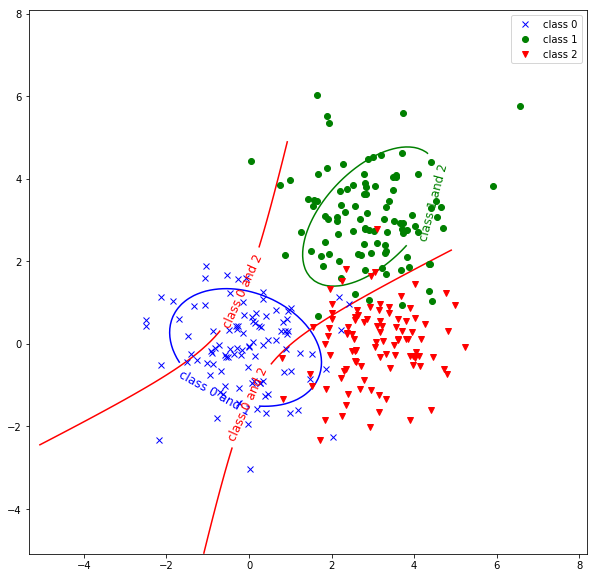

In [16]:
colors= [ 'b', 'g', 'r' ]
shapes = [ 'x', 'o', 'v']

x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)

xx, yy = np.meshgrid(x1, x2)

decision_fn = []
xx_plots = []
yy_plots = []

plt.figure(figsize=(10,10))

for c in range(C):
    data = X[c*N_per_class:(c+1)*N_per_class]
    m = mu[c]
    s = sigma[c]
    inv_s = np.linalg.inv(s)
    
    stylepoint = shapes[c]+colors[c]
    plt.plot(data[:,0], data[:,1], stylepoint, label='class %d'%c)
    
    # contour equation
    z = inv_s[0,0]*xx**2 + 2*inv_s[0,1]*xx*yy + inv_s[1,1]*yy**2
    
    # create a new meshgrid centered on the class mean
    x1_centered = x1 + m[0]
    x2_centered = x2 + m[1]
    xx_plot, yy_plot = np.meshgrid(x1_centered, x2_centered)
    
    xx_plots.append(xx_plot)
    yy_plots.append(yy_plot)
    
    # CS = plt.contour(xx_plot, yy_plot, z, [5, 15], colors=colors[c])
    
    # decision function
    decision_fn.append(discriminative_Gaussian_function(xx, yy, m, s))

# class 0 and class 1
CS = plt.contour(xx_plots[0], yy_plots[0], decision_fn[1]-decision_fn[0], [0], colors='b')
plt.clabel(CS, inline=1, fmt={0: 'class 0 and 1'}, fontsize=12)
    
# class 0 and class 2
CS = plt.contour(xx_plots[0], yy_plots[0], decision_fn[2]-decision_fn[0], [0], colors='r')
plt.clabel(CS, inline=1, fmt={0: 'class 0 and 2'}, fontsize=12)

# class 1 and class 2
CS = plt.contour(xx_plots[1], yy_plots[1], decision_fn[2]-decision_fn[1], [0], colors='g')
plt.clabel(CS, inline=1, fmt={0: 'class 1 and 2'}, fontsize=12)

plt.axis('equal')
plt.legend()
plt.show()

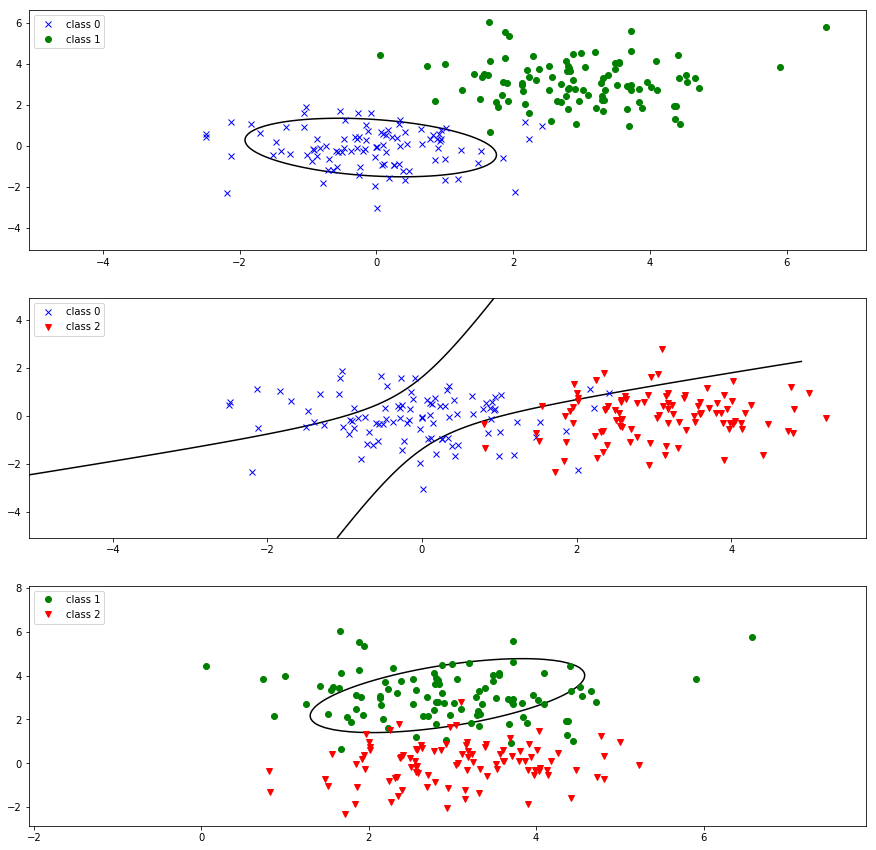

In [20]:
colors= [ 'b', 'g', 'r' ]
shapes = [ 'x', 'o', 'v']

x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)

xx, yy = np.meshgrid(x1, x2)

datas = []
decision_fn = []
xx_plots = []
yy_plots = []

for c in range(C):
    data = X[c*N_per_class:(c+1)*N_per_class]
    datas.append(data)
    
    m = mu[c]
    s = sigma[c]
    inv_s = np.linalg.inv(s)
    
    
    # contour equation
    z = inv_s[0,0]*xx**2 + 2*inv_s[0,1]*xx*yy + inv_s[1,1]*yy**2
    
    # create a new meshgrid centered on the class mean
    x1_centered = x1 + m[0]
    x2_centered = x2 + m[1]
    xx_plot, yy_plot = np.meshgrid(x1_centered, x2_centered)
    
    xx_plots.append(xx_plot)
    yy_plots.append(yy_plot)
    
    # CS = plt.contour(xx_plot, yy_plot, z, [5, 15], colors=colors[c])
    
    # decision function
    decision_fn.append(discriminative_Gaussian_function(xx, yy, m, s))

# plot the boundaries for the three pairs of classes
f, axarr = plt.subplots(3, figsize=(15,15))

for i, cs in enumerate([[0,1], [0,2], [1,2]]):
    c1, c2 = cs
    ind_subplot=i
    stylepoint = shapes[c1]+colors[c1]
    axarr[ind_subplot].plot(datas[c1][:,0], datas[c1][:,1], stylepoint, label='class %d'%c1)
    
    stylepoint = shapes[c2]+colors[c2]
    axarr[ind_subplot].plot(datas[c2][:,0], datas[c2][:,1], stylepoint, label='class %d'%c2)
    axarr[ind_subplot].contour(xx_plots[c1], yy_plots[c1], decision_fn[c2]-decision_fn[c1], [0], colors='k')
    axarr[ind_subplot].legend(loc='upper left')

plt.show()